# Linear viscoelasticity

In this numerical tour, we will explore the formulation of simple linear viscoelastic behaviours such as Maxwell, Kelvin-Voigt or Standard Linear Solid models. The formulation can also be quite easily extended to a generalized Maxwell model.

## Constitutive evolution equations

### 1D rheological formulation


We consider a 1D Linear Standard Solid model consisting of a spring of stiffness $E_0$ in parallel to a Maxwell arm (spring of stiffness $E_1$ in serie with a dashpot of viscosity $\eta_1$). The uniaxial stress for this rheological model can be decomposed as the sum of a reversible and an irreversible stress:

\begin{equation}
\sigma = E_0\varepsilon + E_1(\varepsilon-\varepsilon^v)
\end{equation}
whereas the evolution equation for the viscous internal strain is given by:
\begin{equation}
\dot{\varepsilon}^v = \dfrac{E_1}{\eta_1}(\varepsilon-\varepsilon^v)
\end{equation}

The extension to a generalized Maxwell model with $N$ internal strains is given by:

\begin{align}
\sigma &= E_0\varepsilon + \sum_{i=1}^N E_i(\varepsilon-\varepsilon^{v,i}) \\
\dot{\varepsilon}^{v,i} &= \dfrac{E_i}{\eta_i}(\varepsilon-\varepsilon^{v,i}) \quad \forall i=1,\ldots, N
\end{align}


### 3D generalization

For the 3D case, isotropic viscoelasticity is characterized by two elastic moduli (resp. two viscosities, or equivalently two relaxation times) for each spring (resp. dashpot) element of the 1D model. Here, we will restrict to a simpler case in which one modulus is common to all elements (similar Poisson ratio for all elements), that is:

\begin{align}
\boldsymbol{\sigma} = E_0\mathbb{c}:\boldsymbol{\varepsilon} + E_1\mathbb{c}:(\boldsymbol{\varepsilon}-\boldsymbol{\varepsilon}^v) \\
\dot{\boldsymbol{\varepsilon}}^v = \dfrac{E_1}{\eta_1}\mathbb{c}:(\boldsymbol{\varepsilon}-\boldsymbol{\varepsilon}^v)
\end{align}
where $\mathbb{c} = \dfrac{\nu}{(1+\nu)(1-2\nu)}\mathbf{1}\otimes\mathbf{1} + \dfrac{1}{1+\nu}\mathbb{I}$ with $\mathbf{1}$ and $\mathbb{I}$ being respectively the 2nd and 4th order identity tensors and $\nu$ being the Poisson ratio.


## Problem position

We consider here a 2D rectangular domain of dimensions $L\times H$. The constitutive relations are written in plane stress conditions, the unitary stiffness tensor is therefore  $\mathbb{c} = \dfrac{\nu}{1-\nu^2}\mathbf{1}\otimes\mathbf{1} + \dfrac{1}{1+\nu}\mathbb{I}$. The boundary conditions consist of symmetry planes on $x=0$ and $y=0$ and smooth contact with a plane with imposed vertical displacement on $y=H$ or imposed vertical uniform traction depending on the load case. The solution will therefore be homogeneous in the sample. 

In [1]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

L, H = 0.1, 0.2
mesh = RectangleMesh(Point(0., 0.), Point(L, H), 5, 10)

E0 = Constant(70e3)
E1 = Constant(20e3)
eta1 = Constant(1e3)
nu = Constant(0.)
dt = Constant(0.) # time increment
sigc = 100. # imposed creep stress
epsr = 1e-3 # imposed relaxation strain

def left(x, on_boundary):
    return near(x[0], 0.) and on_boundary
def bottom(x, on_boundary):
    return near(x[1], 0.) and on_boundary
class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H) and on_boundary

facets = MeshFunction("size_t", mesh, 1)
facets.set_all(0)
Top().mark(facets, 1)
ds = Measure("ds", subdomain_data=facets)    

## Time discretization and formulation of the variational problem

Here we will discuss the time discretization of the viscoelastic constitutive equations and the formulation of the global problem using FEniCS.

### A first approach

A first approach for formulating the time-discretized equations consists in approximating the viscous strain evolution equation using an implicit backward-Euler scheme at a given time $t_{n+1}$:

\begin{equation}
\dfrac{\varepsilon^{v,n+1}-\varepsilon^{v,n}}{\Delta t} \approx \dot{\varepsilon}^{v,n+1}= \dfrac{E_1}{\eta_1}(\varepsilon^{n+1}-\varepsilon^{v, n+1})
\end{equation}

which can be rewritten as:
\begin{equation}
\varepsilon^{v,n+1}=  \left(1+\dfrac{\Delta tE_1}{\eta_1}\right)^{-1}\left(\varepsilon^{v,n} +\dfrac{\Delta t E_1}{\eta_1}\varepsilon^{n+1}\right)
\end{equation}

**Note:** In the 3D case, the previous expression is more involved since one must invert the following 4-th order tensor: $\mathbb{I} + \dfrac{\Delta tE_1}{\eta_1}\mathbb{c}$

Introducing $\tau = \eta_1/E_1$ and plugging the previous relation into the stress-strain relation, one obtains:

\begin{align}
\sigma_{n+1} &= (E_0+E_1)\varepsilon^{n+1} - E_1\dfrac{\Delta t/\tau}{1+\Delta t/\tau}\varepsilon^{n+1} - E_1\varepsilon^{v,n} \\
&= \left(E_0 + \dfrac{E_1}{1+\Delta t/\tau}\right)\varepsilon^{n+1} - \dfrac{E_1}{1+\Delta t/\tau}\varepsilon^{v,n}
\end{align}

A possible solution for solving these simple linear viscoelastic behaviours would then be to formulate exactly the problem associated with the previous stress-strain relation, taking into account the modified elasticity tensor depending on the time step $\Delta t$ and the value of the previous viscous strain. As a result, one would have a pure displacement problem. After solving for $u$ at a given time step, the new viscous strain would have to be updated using the previous relations.

### A mixed approach

One problematic aspect of the previous approach is that it requires inverting the modified elasticity tensor which poses no problem in the present case but may not be possible for more general non-linear behaviours for instance. We hence propose a more general approach which amounts to solving both the displacement-problem and the viscous strain update in a monolothic way. The formulation can be derived from an incremental variational principle by defining the following incremental potential:

\begin{equation}
\mathcal{E} = \int_{\Omega} w(\boldsymbol{\varepsilon}, \dot{\boldsymbol{\varepsilon}}^v)d\Omega + \Delta t \int_{\Omega} \phi(\dot{\boldsymbol{\varepsilon}}^v)d\Omega - W_{ext}(\boldsymbol{u})
\end{equation}

where $W_{ext}(\boldsymbol{u})$ is the work of external forces and the strain energy density $w(\boldsymbol{\varepsilon}, \boldsymbol{\varepsilon}^v)$ and the dissipation potential $\phi(\dot{\boldsymbol{\varepsilon}}^v)$ of the Linear Standard Solid model are respectively given by:

\begin{align*}
w(\boldsymbol{\varepsilon},  \boldsymbol{\varepsilon}^v) &= \dfrac{1}{2}\boldsymbol{\varepsilon}:(E_0\mathbb{c}):\boldsymbol{\varepsilon} + \dfrac{1}{2}(\boldsymbol{\varepsilon}-\boldsymbol{\varepsilon}^v):(E_1\mathbb{c}):(\boldsymbol{\varepsilon}-\boldsymbol{\varepsilon}^v) \\
\phi(\dot{\boldsymbol{\varepsilon}}^v) &= \dfrac{1}{2}\eta_1 \dot{\boldsymbol{\varepsilon}}^v:\dot{\boldsymbol{\varepsilon}}^v
\end{align*}

Introducing the backward-Euler approximation 

\begin{equation}
\dot{\boldsymbol{\varepsilon}}^v \approx \dfrac{\boldsymbol{\varepsilon}^{v,n+1}-\boldsymbol{\varepsilon}^{v,n}}{\Delta t}
\end{equation}

into the dissipation potential, the new total and viscous strain variables are obtained as the solution to the following minimization problem:

\begin{equation}
\min_{\boldsymbol{\varepsilon}^{n+1},\:  \boldsymbol{\varepsilon}^{v,n+1}} \mathcal{E}_{n+1} = \int_{\Omega} w(\boldsymbol{\varepsilon}^{n+1},  \boldsymbol{\varepsilon}^{v,n+1})d\Omega + \Delta t \int_{\Omega} \phi\left(\dfrac{\boldsymbol{\varepsilon}^{v,n+1}-\boldsymbol{\varepsilon}^{v,n}}{\Delta t}\right)d\Omega
\end{equation}
which depends on the knowledge of the previous viscous strain $\boldsymbol{\varepsilon}^{v,n}$.

It can be shown that the optimality conditions of the previous minimization problem correspond exactly to the relations of the first approach.

In the FEniCS implementation, we use a CG1 interpolation for the displacement and a DG0 interpolation for the viscoelastic strain. We then define appropriate functions and form the previous incremental potential. We use the `derivative` function for automatic differentiation. Since the considered problem is linear, we also extract the corresponding bilinear and linear parts of the potential derivative.

In [2]:
Ve = VectorElement("CG", mesh.ufl_cell(), 1)
Qe = TensorElement("DG", mesh.ufl_cell(), 0)
W = FunctionSpace(mesh, MixedElement([Ve, Qe]))
w = Function(W, name="Variables at current step")
(u, epsv) = split(w)
w_old = Function(W, name="Variables at previous step")
(u_old, epsv_old) = split(w_old)
w_ = TestFunction(W)
(u_, epsv_) = split(w_)
dw = TrialFunction(W)

def eps(u):
    return sym(grad(u))
def dotC(e):
    return nu/(1+nu)/(1-nu)*tr(e)*Identity(2) + 1/(1+nu)*e
def sigma(u, epsv):    
    return E0*dotC(eps(u)) + E1*dotC(eps(u) - epsv)
def strain_energy(u, epsv):
    e = eps(u)
    return 0.5*(E0*inner(e,dotC(e)) + E1*inner(e-epsv, dotC(e-epsv)))
def dissipation_potential(depsv):
    return 0.5*eta1*inner(depsv, depsv)

Traction = Constant(0.)
incremental_potential = strain_energy(u, epsv)*dx \
                        + dt*dissipation_potential((epsv-epsv_old)/dt)*dx \
                        - Traction*u[1]*ds(1)
F = derivative(incremental_potential, w, w_)
form = replace(F, {w: dw})

## Solutions of elementary tests

In the following, we will consider three elementary tests of viscoelastic behaviour, namely a relaxation, creep and recovery test. We implement a function for setting up the boundary conditions and loading parameters for these three different tests and perform the time integration. We keep track of the average vertical stress and strain states (the problem is such that all fields are uniform in the sample) and compare the evolutions with analytical solutions given below. Parameters have been taken as $E_0= 70\text{ GPa}$, $E_1= 20\text{ GPa}$, $\eta_1 = 1 \text{ GPa.s}$.

In [3]:
dimp = Constant(H*epsr) # imposed vertical displacement instead
bcs = [DirichletBC(W.sub(0).sub(0), Constant(0), left),
       DirichletBC(W.sub(0).sub(1), Constant(0), bottom),
       DirichletBC(W.sub(0).sub(1), dimp, facets, 1)]

def viscoelastic_test(case, Nsteps=50, Tend=1.):
    # Solution fields are initialized to zero
    w.interpolate(Constant((0.,)*6))
    
    # Define proper loading and BCs
    if case in ["creep", "recovery"]: # imposed traction on top
        Traction.assign(Constant(sigc))
        bc = bcs[:2] # remove the last boundary conditions from bcs
        t0 = Tend/2. # traction goes to zero at t0 for recovery test
    elif case == "relaxation":
        Traction.assign(Constant(0.)) # no traction on top
        bc = bcs

    # Time-stepping loop
    time = np.linspace(0, Tend, Nsteps+1)
    Sigyy = np.zeros((Nsteps+1, ))
    Epsyy = np.zeros((Nsteps+1, 2))
    for (i, dti) in enumerate(np.diff(time)):
        if i>0 and i % (Nsteps/5) == 0:
            print("Increment {}/{}".format(i, Nsteps))
        dt.assign(dti)
        if case == "recovery" and time[i+1] > t0:
            Traction.assign(Constant(0.))
        w_old.assign(w)
        solve(lhs(form) == rhs(form), w, bc)
        # get average stress/strain
        Sigyy[i+1] = assemble(sigma(u, epsv)[1, 1]*dx)/L/H
        Epsyy[i+1, 0] = assemble(eps(u)[1, 1]*dx)/L/H
        Epsyy[i+1, 1] = assemble(epsv[1, 1]*dx)/L/H
    
    # Define analytical solutions
    if case == "creep":
        if float(E0) == 0.:
            eps_an = sigc*(1./float(E1)+time/float(eta1))
        else:
            Estar = float(E0*E1/(E0+E1))
            tau = float(eta1)/Estar
            eps_an = sigc/float(E0)*(1-float(Estar/E0)*np.exp(-time/tau))
        sig_an = sigc + 0*time
    elif case == "relaxation":
        if float(E1) == 0.:
            sig_an = epsr*float(E0) + 0*time
        else:
            tau = float(eta1/E1)
            sig_an = epsr*(float(E0) + float(E1)*np.exp(-time/tau))
        eps_an = epsr + 0*time
        
    elif case == "recovery":
        Estar = float(E0*E1/(E0+E1))
        tau = float(eta1)/Estar
        eps_an = sigc/float(E0)*(1-float(E1/(E0+E1))*np.exp(-time/tau))
        sig_an = sigc + 0*time
        time2 = time[time > t0]
        sig_an[time > t0] = 0.
        eps_an[time > t0] = sigc*float(E1/E0/(E0+E1))*(np.exp(-(time2-t0)/tau)
                                                       - np.exp(-time2/tau))
        
    # Plot strain evolution
    plt.figure()
    plt.plot(time, 100*eps_an, label="analytical solution")
    plt.plot(time, 100*Epsyy[:, 0], '.', label="FE solution")
    plt.plot(time, 100*Epsyy[:, 1], '--', linewidth=1, label="viscous strain")
    plt.ylim(0, 1.2*max(Epsyy[:, 0])*100)
    plt.xlabel("Time")
    plt.ylabel("Vertical strain [\%]")
    plt.title(case.capitalize() + " test")
    plt.legend()
    plt.show()
    
    # Plot stress evolution
    plt.figure()
    plt.plot(time, sig_an, label="analytical solution")
    plt.plot(time, Sigyy, '.', label="FE solution")
    plt.ylim(0, 1.2*max(Sigyy))
    plt.ylabel("Vertical stress")
    plt.xlabel("Time")
    plt.title(case.capitalize() + " test")
    plt.legend()
    plt.show()

### Relaxation test

First we consider a relaxation test in which the top surface is instantaneously displaced and maintained fixed, generating a uniform and constant uniaxial strain state $\varepsilon_{yy} = \varepsilon_r$. Resolving the 1D evolution equation for this test gives:

\begin{equation}
\sigma_{yy}(t) = E_0\varepsilon_r + E_1\varepsilon_r \exp(-t/\tau) \quad \text{with } \tau = \dfrac{\eta_1}{E_1}
\end{equation}

The analytical solution is well reproduced by the FE solution as seen below. The instantaneous stress being $\sigma_{yy}(t=0^+) = (E_0+E_1)\varepsilon_r$ whereas the long term stress is being given by $\sigma_{yy}(t=\infty) = E_0\varepsilon_r$.

Increment 10/50
Increment 20/50
Increment 30/50
Increment 40/50


<IPython.core.display.Javascript object>


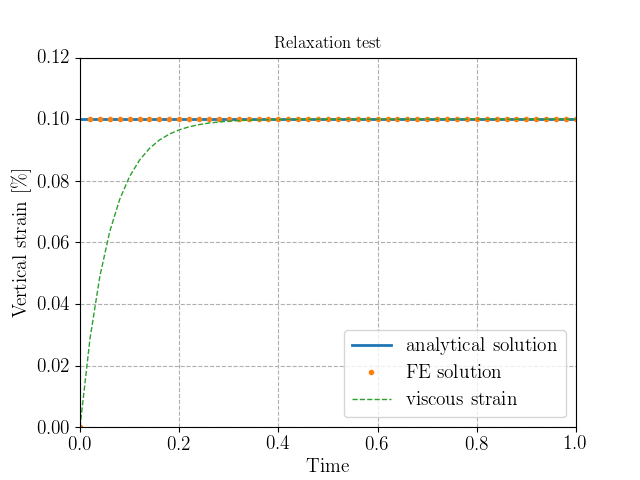

<IPython.core.display.Javascript object>


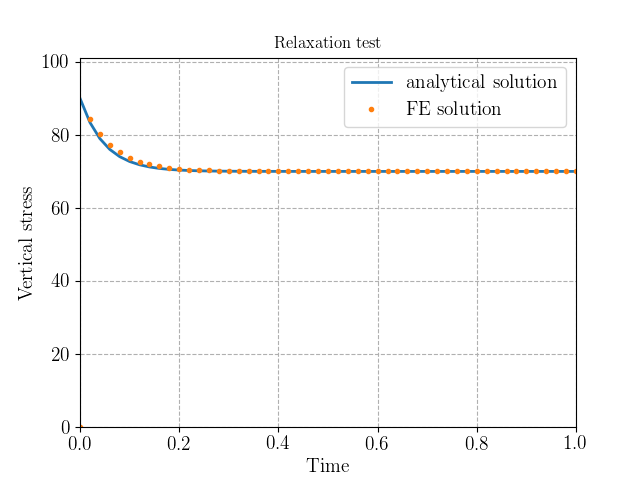

In [4]:
viscoelastic_test("relaxation")

### Creep test

We now consider a creep test in which a uniform vertical traction of intensity $\sigma_c$ is suddenly applied and maintained constant. The integration of the evolution equation gives in this case:

\begin{equation}
\varepsilon_{yy}(t) = \dfrac{\sigma_c}{E_0}\left(1- \dfrac{E_1}{E_0+E_1}\exp(-t/\tau)\right) \quad \text{with } \tau = \dfrac{\eta_1(E_0+E_1)}{E_0E_1}
\end{equation}

Again, the solution is well reproduced. The instantaneous strain is $\varepsilon_{yy}(t=0^+) = \dfrac{\sigma_c}{E_0+E_1}$ whereas the long term strain is being given by $\varepsilon_{yy}(t=\infty) = \dfrac{\sigma_c}{E_0}$.

Increment 10/50
Increment 20/50
Increment 30/50
Increment 40/50


<IPython.core.display.Javascript object>


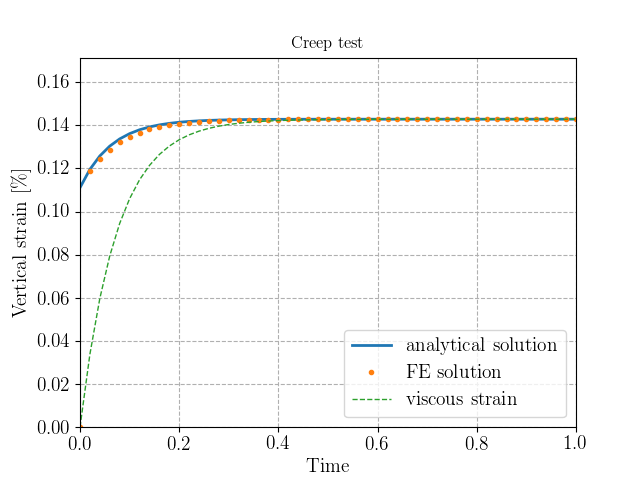

<IPython.core.display.Javascript object>


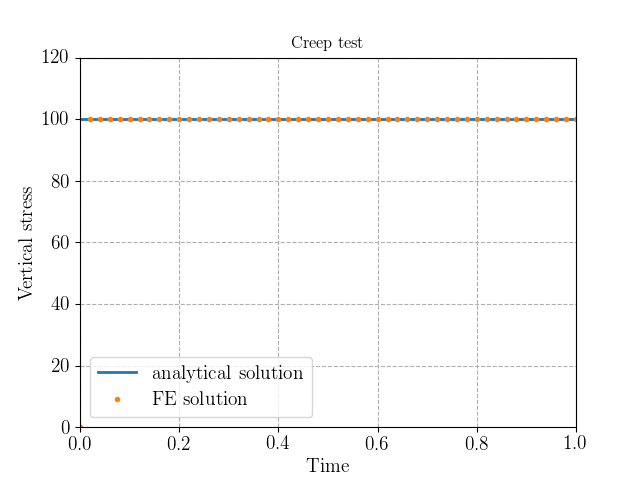

In [5]:
viscoelastic_test("creep")

### Recovery test

Finally, we consider again the same creep test as before up to $t=t_0=0.5$, after which the imposed traction is suddenly removed. The solution is the same as before during the first stage whereas during the second stage it is given by:

\begin{equation}
\varepsilon_{yy}(t) = \dfrac{\sigma_c E_1}{E_0(E_0+E_1)}\left(\exp(-(t-t_0)/\tau) - \exp(-t/\tau)\right) \quad \text{with } \tau = \dfrac{\eta_1(E_0+E_1)}{E_0E_1}
\end{equation}

Increment 10/50
Increment 20/50
Increment 30/50
Increment 40/50


<IPython.core.display.Javascript object>


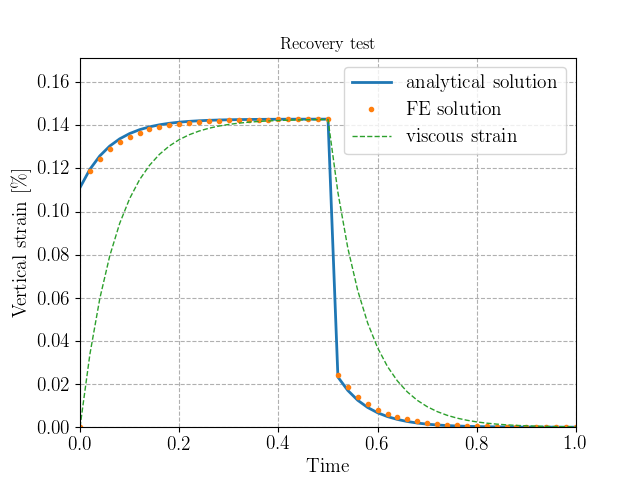

<IPython.core.display.Javascript object>


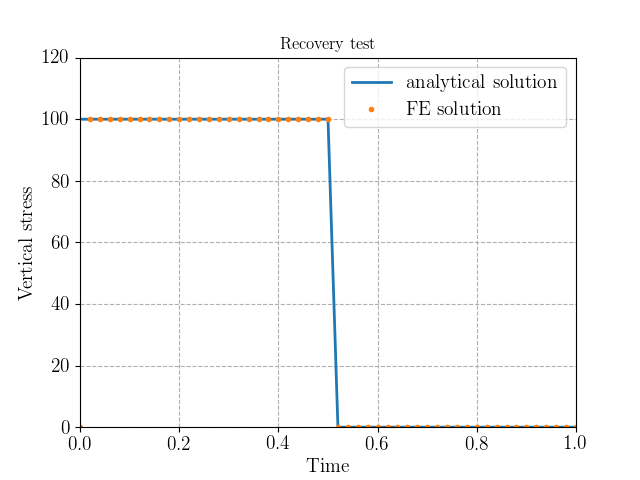

In [6]:
viscoelastic_test("recovery")

## Relaxation and creep tests for a Maxwell model

We give here the solutions for a Maxwell model which is obtained from the degenerate case $E_0=0$. We recover that the strain evolves linearly with time for the creep test.

Increment 10/50
Increment 20/50
Increment 30/50
Increment 40/50


<IPython.core.display.Javascript object>


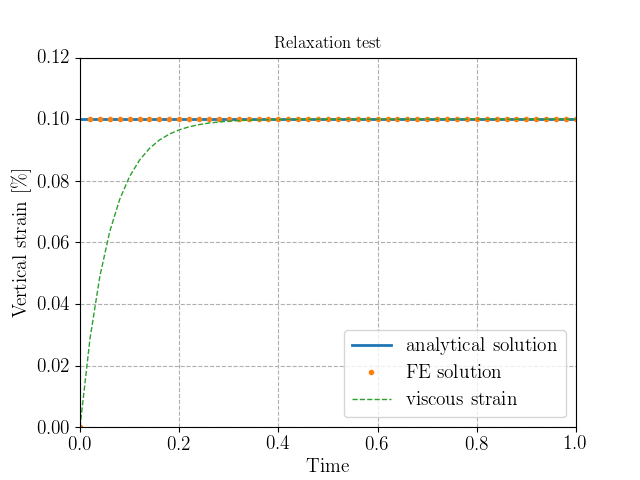

<IPython.core.display.Javascript object>


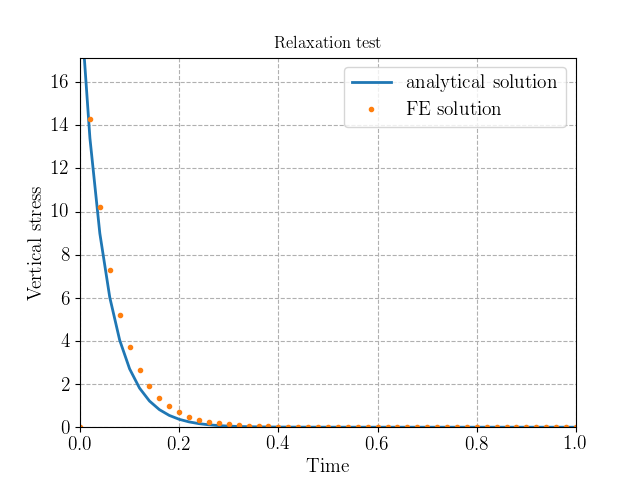

Increment 10/50
Increment 20/50
Increment 30/50
Increment 40/50


<IPython.core.display.Javascript object>


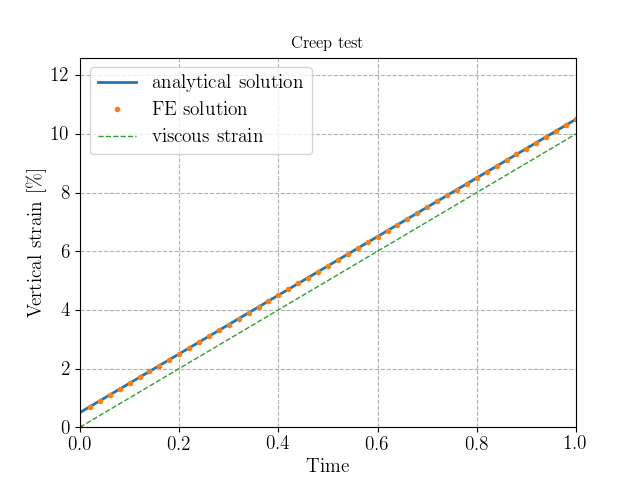

<IPython.core.display.Javascript object>


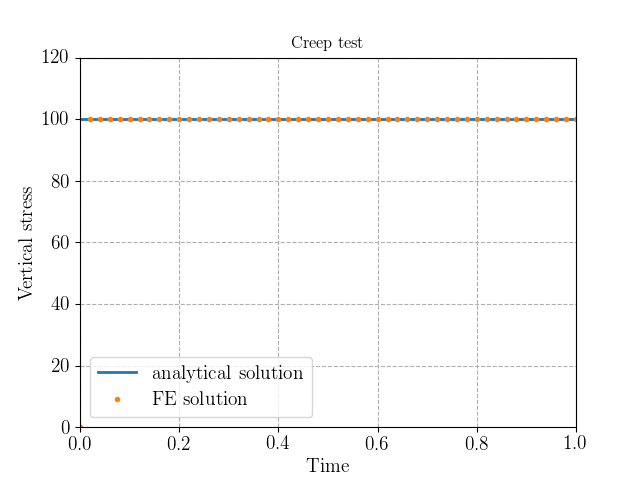

In [7]:
E0.assign(Constant(0.))
viscoelastic_test("relaxation")
viscoelastic_test("creep")

## Relaxation and creep tests for a Kelvin-Voigt model

We give here the solutions for a Kelvin-Voigt model which is obtained from the degenerate case $E_1=\infty$. We recover that the stress is constant for the relaxation test.

Increment 10/50
Increment 20/50
Increment 30/50
Increment 40/50


<IPython.core.display.Javascript object>


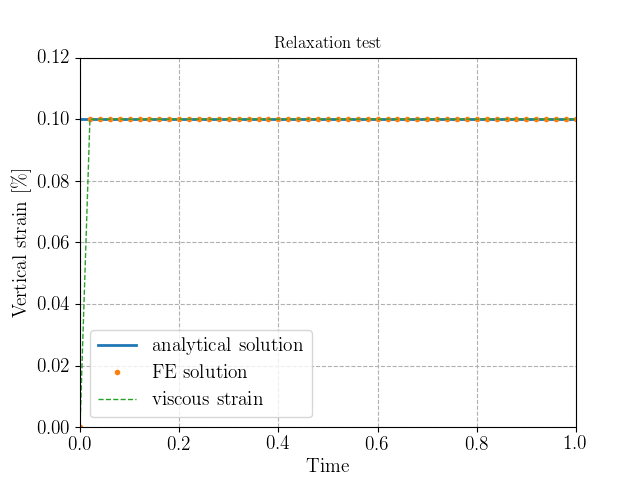

<IPython.core.display.Javascript object>


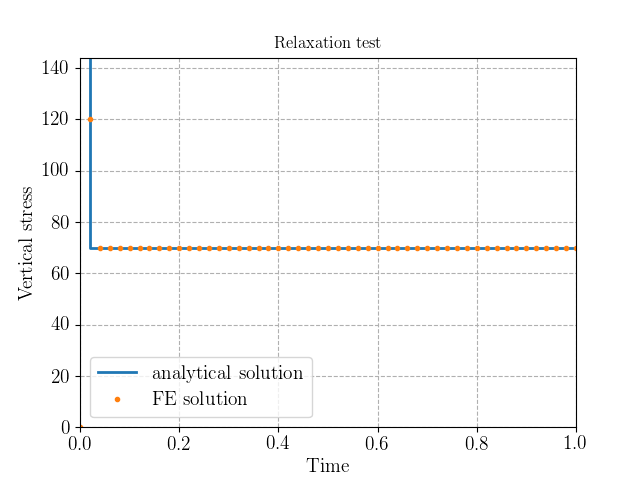

Increment 10/50
Increment 20/50
Increment 30/50
Increment 40/50


<IPython.core.display.Javascript object>


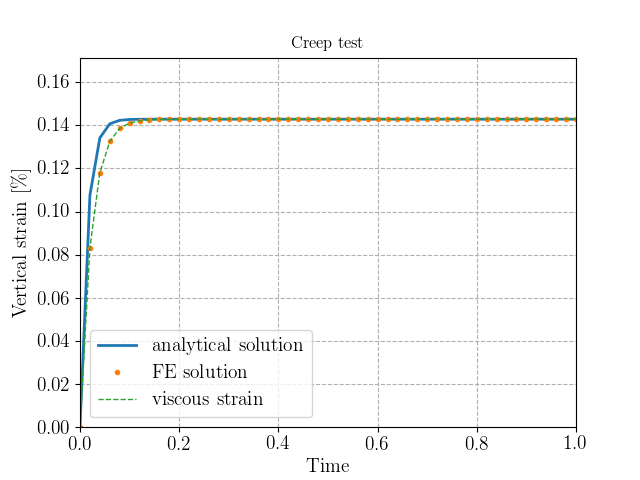

<IPython.core.display.Javascript object>


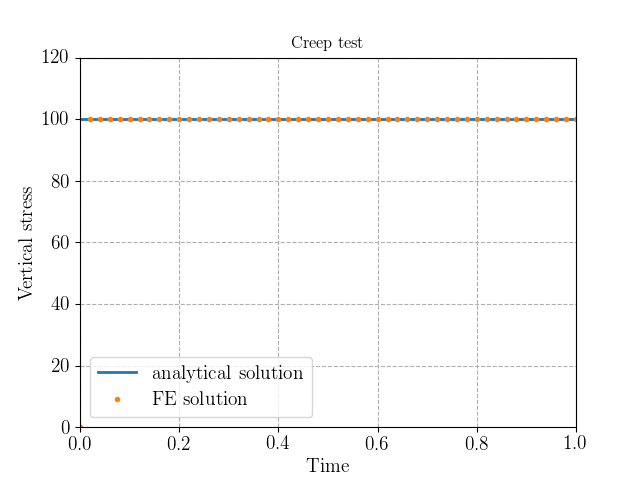

In [8]:
E0.assign(Constant(70e3))
E1.assign(Constant(1e10))
viscoelastic_test("relaxation")
viscoelastic_test("creep")